# Your Title Here

**Name(s)**: (your name(s) here)

**Website Link**: (your website link)

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import math

import plotly.express as px
pd.options.plotting.backend = 'plotly'

from dsc80_utils import * # Feel free to uncomment and use this.

In [2]:
import sys

# Print the list of directories in the Python module search path
print(sys.path)

['c:\\Users\\jiaxin\\Recipe-Rating-Analysis-Prediction', 'c:\\Users\\jiaxin\\miniforge3\\envs\\dsc80\\python38.zip', 'c:\\Users\\jiaxin\\miniforge3\\envs\\dsc80\\DLLs', 'c:\\Users\\jiaxin\\miniforge3\\envs\\dsc80\\lib', 'c:\\Users\\jiaxin\\miniforge3\\envs\\dsc80', '', 'c:\\Users\\jiaxin\\miniforge3\\envs\\dsc80\\lib\\site-packages', 'c:\\Users\\jiaxin\\miniforge3\\envs\\dsc80\\lib\\site-packages\\win32', 'c:\\Users\\jiaxin\\miniforge3\\envs\\dsc80\\lib\\site-packages\\win32\\lib', 'c:\\Users\\jiaxin\\miniforge3\\envs\\dsc80\\lib\\site-packages\\Pythonwin']


## Step 1: Introduction

In [3]:
# TODO

## Step 2: Data Cleaning and Exploratory Data Analysis

DATA CLEANING

In [6]:
recipes_raw = pd.read_csv("RAW_recipes.csv")
interactions_raw = pd.read_csv("RAW_interactions.csv")
merged_recipes = recipes_raw.merge(interactions_raw, left_on = "id", right_on = "recipe_id", how="left")

In [ ]:
merged_recipes["rating"] = merged_recipes["rating"].replace(0, np.NaN)

In [ ]:
num_reviews = merged_recipes.groupby("id").count()[["name"]]
num_reviews = num_reviews.rename(columns = {"name": "num_reviews"})

In [ ]:
total_reviews = merged_recipes.groupby("id")[["review"]].sum().reset_index()
total_reviews = total_reviews.rename(columns = {"review": "reviews"})
total_reviews = total_reviews.replace(0, "")

In [ ]:
average_ratings = merged_recipes.groupby("id").mean()[["rating"]].reset_index()
average_ratings = average_ratings.rename(columns = {"rating": "average_ratings"})
recipes = recipes_raw.merge(average_ratings, on = "id", how = "left")
recipes = recipes.merge(num_reviews, on = "id", how = "left")
recipes = recipes.merge(total_reviews, on = "id", how = "left")

In [ ]:
nutrition = recipes["nutrition"].str.strip("[]").str.split(",")
for i in range(len(nutrition)):
    for x in range(len(nutrition.iloc[i])):
        nutrition.iloc[i][x] = float(nutrition.iloc[i][x])

In [ ]:
recipes["calories"] = nutrition.str[0]
recipes["total fat"] = nutrition.str[1]
recipes["sugar"] = nutrition.str[2]
recipes["sodium"] = nutrition.str[3]
recipes["protein"] = nutrition.str[4]
recipes["saturated fat"] = nutrition.str[5]
recipes["carbohydrates"] = nutrition.str[6]
recipes = recipes.drop(columns = "nutrition")


In [ ]:
def categorize_season(date):
    # Convert column to datetime
    dates = pd.to_datetime(date)
    # Extract month from datetime
    month = dates.month
    # Categorize seasons
    if month in [12, 1, 2]:
        return "winter"
    if month in [3, 4, 5]:
        return "spring"
    if month in [6, 7, 8]:
        return "summer"
    return "fall"

In [ ]:
recipes["season"] = recipes["submitted"].apply(categorize_season)

UNIVARIATE ANALYSIS

In [5]:
px.box(recipes, y="average_ratings", title = "Distribution of Ratings")

NameError: name 'recipes' is not defined

Generally, recipes are getting pretty good ratings, but there is a lot of variability.


In [14]:
recipes["average_ratings"].mean()

4.625363316968541

BIVARIATE ANALYSIS

In [12]:
a = pd.qcut(recipes['carbohydrates'], q=2, labels=False)
px.box(recipes, y='average_ratings', x=a+1,
                 title='Amount of Carbohydrates vs Ratings',
                 labels={'x': 'Carbohydrates Quantiles', 
                         "average_ratings": "Average Ratings"})

In [28]:
fig = px.scatter(recipes, x='average_ratings', y='num_reviews',
                 title='Ratings vs. Popularity')
fig

As ratings goes up, number of reviews appears to go up.

In [21]:
fig = px.scatter(recipes, x='average_ratings', y='n_steps',
                 title='Ratings vs. Number of Steps')
fig

In [164]:
fig = px.bar(recipes, x="season", y="average_ratings")
fig.show()

INTERESTING AGGREGATES

In [25]:
recipes["rating_star"] = recipes["average_ratings"].apply(np.floor)
recipes.groupby("rating_star")[["num_reviews", "n_steps", "n_ingredients"]].mean()

num_reviews    n_steps  n_ingredients
rating_star                                       
1.0             1.242623  10.498361       9.031148
2.0             1.717500  10.573750       9.176250
3.0             2.375381  10.038325       9.215736
4.0             4.288206   9.754413       9.206034
5.0             2.091160  10.225117       9.208082

In [29]:
recipes.groupby("rating_star")[["calories", "total fat", "sugar", "sodium", "protein", "saturated fat", "carbohydrates"]].mean()

calories  total fat      sugar     sodium    protein  \
rating_star                                                           
1.0          446.125082  34.762295  75.847541  47.377049  29.650820   
2.0          442.994000  33.566250  74.216250  33.135000  30.467500   
3.0          444.706193  32.291371  80.575127  33.264721  33.794416   
4.0          411.912283  30.559328  59.382824  27.573844  34.037020   
5.0          434.205891  33.438620  71.499791  29.100850  32.569626   

             saturated fat  carbohydrates  
rating_star                                
1.0              44.540984      14.837705  
2.0              44.433750      15.056250  
3.0              40.175635      15.216244  
4.0              37.371768      13.102464  
5.0              41.318119      13.848213

Of note: Number of reviews, sodium content, sugar

## Step 3: Assessment of Missingness

In [22]:
recipes.columns

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients',
       'average_ratings', 'num_reviews', 'reviews', 'calories', 'total fat',
       'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates'],
      dtype='object')

In [48]:
print(recipes.isna().sum())
# Name missing 1, description missing 70, average_ratings missing 2609
# We assume the missing of average ratings is correlated with other quantitative values

name                1
id                  0
minutes             0
contributor_id      0
submitted           0
tags                0
n_steps             0
steps               0
description        70
ingredients         0
n_ingredients       0
average_ratings     0
num_reviews         0
reviews             0
calories            0
total fat           0
sugar               0
sodium              0
protein             0
saturated fat       0
carbohydrates       0
n_steps_bins        0
Random Steps        0
Random Review       0
dtype: int64


Column: minutes
Observed Difference: 117.34218767985172
P-value: 0.038



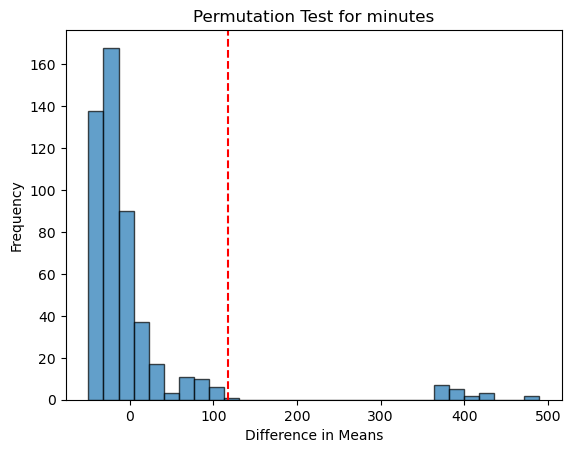

Column: num_reviews
Observed Difference: -1.7897968695935287
P-value: 1.0



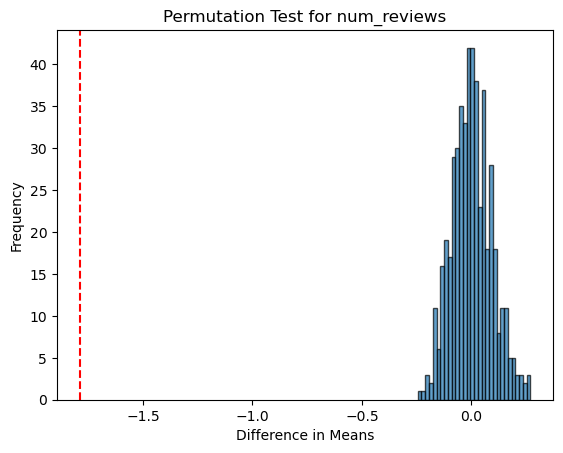

Column: n_steps
Observed Difference: 1.4929874350905923
P-value: 0.0



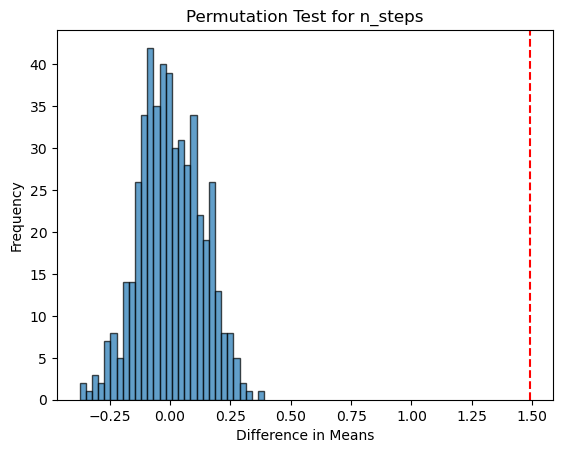

Column: n_ingredients
Observed Difference: 0.25422661366086885
P-value: 0.002



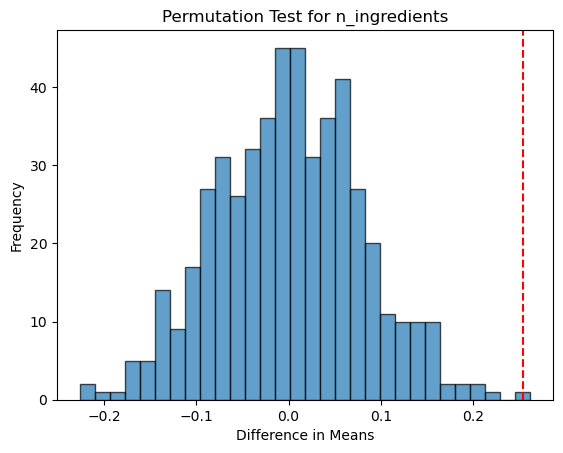

Column: total fat
Observed Difference: 7.25240757810225
P-value: 0.0



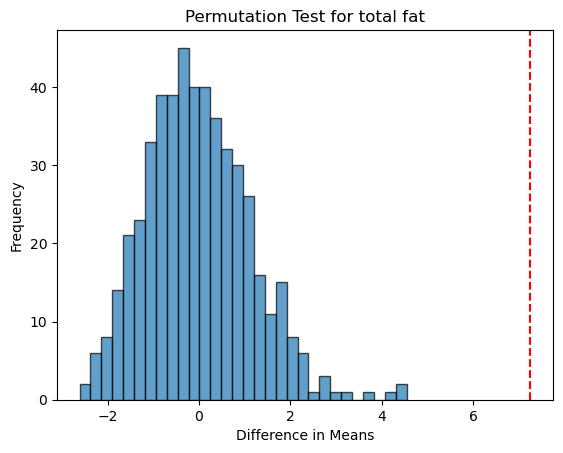

Column: sugar
Observed Difference: 27.29957581948925
P-value: 0.002



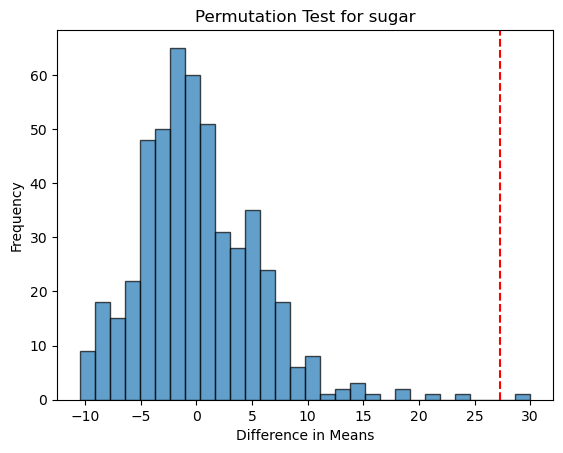

Column: sodium
Observed Difference: -0.35044865846552753
P-value: 0.44



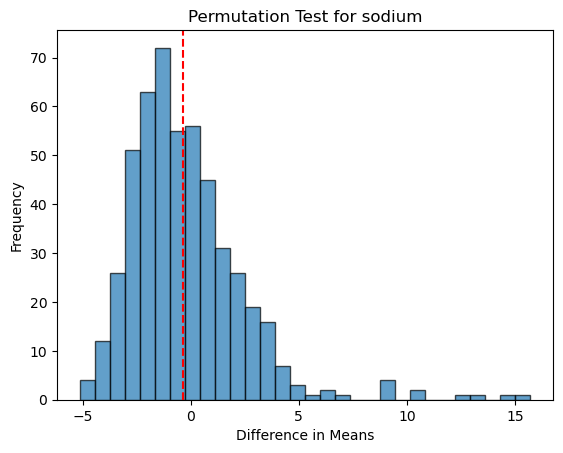

Column: protein
Observed Difference: 1.2873110276228346
P-value: 0.096



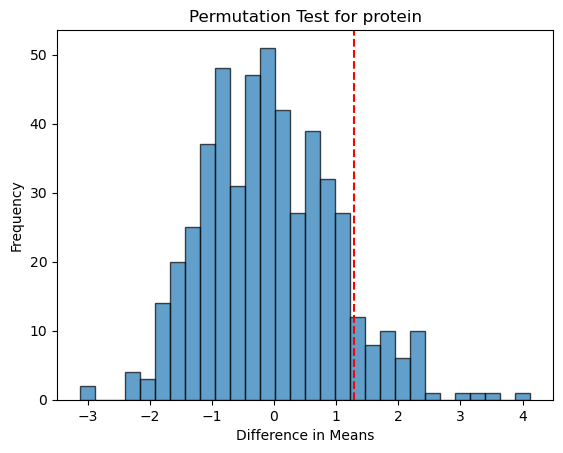

Column: saturated fat
Observed Difference: 9.307738753127133
P-value: 0.0



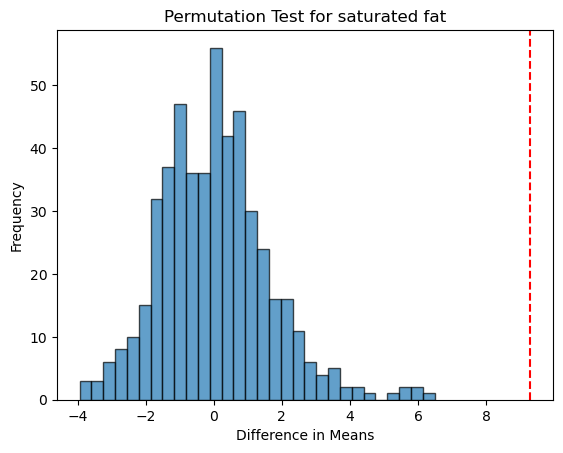

Column: carbohydrates
Observed Difference: 3.545182917979499
P-value: 0.0



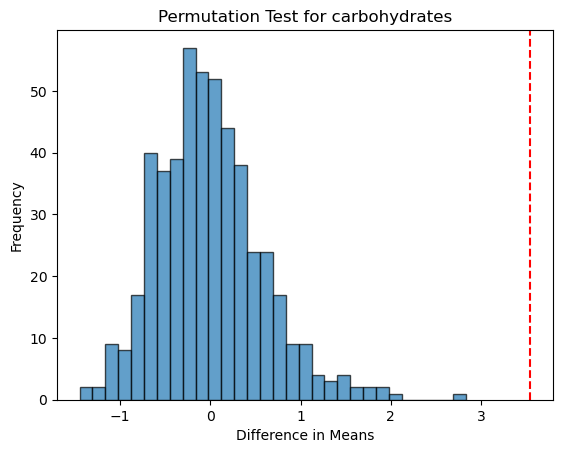

In [66]:
import matplotlib.pyplot as plt

def permutation_test(data, col, n_permutations=500):
    observed_diff = data.groupby(data['average_ratings'].isna())[col].mean().diff().iloc[-1]
    perm_diffs = []

    for _ in range(n_permutations):
        permuted = data[col].sample(frac=1, replace=False).reset_index(drop=True)
        permuted_diff = data.assign(**{col: permuted}).groupby(data['average_ratings'].isna())[col].mean().diff().iloc[-1]
        perm_diffs.append(permuted_diff)
    
    perm_diffs = np.array(perm_diffs)
    p_value = np.mean(perm_diffs >= observed_diff)
    
    return  observed_diff, perm_diffs, p_value

quantitative_cols = ['minutes', "num_reviews", 'n_steps', 'n_ingredients', 'total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']
result_dict = {}
for col in quantitative_cols:
    # result_dict[col] = permutation_test(recipes, col)
    observed_diff, perm_diffs, p_value = permutation_test(recipes, col)
    print(f"Column: {col}")
    print(f"Observed Difference: {observed_diff}")
    print(f"P-value: {p_value}\n")

    plt.hist(perm_diffs, bins=30, edgecolor='k', alpha=0.7)
    plt.axvline(observed_diff, color='r', linestyle='--')
    plt.title(f'Permutation Test for {col}')
    plt.xlabel('Difference in Means')
    plt.ylabel('Frequency')
    plt.show()

# result_dict


Taking alpha level of 0.05, we **reject** the null hypothesis that the missingness of average_rating is not related to the value of other columns.  
Based on the results we got, it was influenced by num_reviews, n_steps, n_ingredients, total fat, sugar, saturated fat, and carbohydrates.  
That means, the missingness of average_rating should be MAR (missing at random)

We decided to do imputation based on number of reviews. The results suggest that recipes with missing rating tend to have xxx number of reviews and thus xxx

In [72]:
def prob_impute(s):
    s = s.copy()
    
    # Step 1: Find the number of missing child heights for that gender.
    num_null = s.isna().sum()
    
    # Step 2: Sample num_null observed child heights for that gender.
    #print(len(s.dropna()))
    fill_values = np.random.choice(s.dropna(), num_null)
    
    # Step 3: Fill in missing values and return ser.
    s[s.isna()] = fill_values
    return s

In [12]:
average_ratings_pfilled = recipes.copy()
average_ratings_pfilled['average_ratings'] = (
    recipes
    .groupby('num_reviews')
    ['average_ratings']
    .transform(prob_impute)
)
average_ratings_pfilled.head()

ValueError: 'a' cannot be empty unless no samples are taken

Some groups may have no NaNs...

In [73]:

recipes["quantiles_num_reviews"] = pd.qcut(recipes["num_reviews"], q=100, labels=False, duplicates='drop')

# Apply probabilistic imputation within each bin
average_ratings_pfilled = recipes.copy()
average_ratings_pfilled['average_ratings'] = (
    recipes
    .groupby('quantiles_num_reviews')
    ['average_ratings']
    .transform(prob_impute)
)

recipes_not_pfilled = recipes
recipes = average_ratings_pfilled.drop(columns = "quantiles_num_reviews")

In [14]:
recipes_not_pfilled["average_ratings"].mean()

4.625363316968541

In [15]:
recipes["average_ratings"].mean()

4.624405598596604

## Step 4: Hypothesis Testing

Null Hypothesis: There is no association between number of reviews and ratings.

Alternative Hypothesis: There is a significant association between number of reviews and ratings.
 

In [104]:
observed_coefficient = recipes['average_ratings'].corr(recipes['num_reviews'])
observed_coefficient

0.04688113769480654

In [105]:
num_iterations = 1000

sampled_correlations = []

recipe_copy = recipes

for i in range(num_iterations):
    recipe_copy["Random Review"] = np.random.choice(recipes["num_reviews"], recipes.shape[0], replace=True)
    corr = recipe_copy['average_ratings'].corr(recipe_copy["Random Review"])
    sampled_correlations.append(corr)

np.mean(sampled_correlations >= observed_coefficient)

0.0

p < 0.05. Thus, we reject the null hypothesis that number of steps is correlated to average ratings. 

## Step 5: Framing a Prediction Problem

Report:  
We focused on some quantitative features in our dataset, which are:   
Number of steps in recipe (n_steps),  
The number of ingredients of the recipe (n_ingredients),  
The amount of fat in recipe (total fat),
The amount of protein in recipe (protein),  
and The amount of carbohydrates in recipe (carbohydrates).  

We plan to create a **regression model** using above features to predict the **average rating** of the recipe. The reason we choose average rating is because the ratings shows people's ovarall preference of the compositions of the recipe, and 

(Metric, eg: F1 or accuracy)

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Step 6: Baseline Model

Report:  
Features:  
Number of steps in recipe (quantitative),  
The number of ingredients of the recipe (quantitative),  
The amount of fat in recipe (quantitative),
The amount of protein in recipe (quantitative),  
and The amount of carbohydrates in recipe (quantitative).  

Need: Performance of the model  
Whether I believe my current model is "good" and why

In [17]:
features = ["num_reviews", "sodium"]


X = recipes[features]
y = recipes['average_ratings'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pl = Pipeline([
    ('regression', LinearRegression())
])

pl.fit(X_train, y_train)
y_pred = pl.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print("rmse:", rmse, "r2:", r2)


rmse: 0.6441589579974127 r2: 0.00155018170515564


In [18]:
feature_names = ["num_reviews", "sodium"]
coefficients = pl.named_steps['regression'].coef_
for feature_name, coefficient in zip(feature_names, coefficients):
    print(f"{feature_name}: {coefficient}")

num_reviews: 0.006479857489384066
sodium: -5.12961111613889e-05


Our model has Mean Squared Error of 1.07, and $R^2$ value of 0.0008.   
That means there are some variances between the prediction of our model and the true value. The very low $R^2$ value means our model cannot explain the variance of the dataset.    
Underfitting becuase...  
Adding more features...  
We should not use this model to predict the average_rating of a recipe.  
We should make some changes on the current model or choose another new model.

## Step 7: Final Model

In [115]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder



In [98]:
from scipy.stats import pearsonr

# Assuming sentiment_scores and ratings are arrays or pandas Series containing sentiment scores and ratings
correlation_coefficient, p_value = pearsonr(recipes["sentiment"], recipes["average_ratings"])
correlation_coefficient, p_value

(0.30253408420919903, 1.3032075195058043e-22)

In [176]:
from sklearn.base import BaseEstimator, TransformerMixin

class SentimentAnalyzer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.analyzer = SentimentIntensityAnalyzer()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        sentiment_scores = []
        for review in X["reviews"]:
            scores = self.analyzer.polarity_scores(review)
            sentiment_scores.append(scores['compound']) #overall sentiment; -1 is negative and +1 is positive
        return np.array(sentiment_scores).reshape(-1, 1)
    
    def get_feature_names_out(self, input_features):
        return ['pos_neg_score']

Other hyperparameters we could have tried but didn't because it would affect ability to compare coefficients:

drop = "first" or None. If we chose None, we could not interpret the coef due to mulitcolliniarity

standard scalar = with_mean or with_std = False would again render the coefficients uninterpretable

Thus, the primary hyperparameter to check was whether or not we should do a coefficient

In [173]:
from sklearn.model_selection import GridSearchCV

features = ["num_reviews", "n_steps", "calories", "sodium", "reviews", "season"]

X = recipes[features]
y = recipes['average_ratings'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

preprocessor = ColumnTransformer(
    transformers=[
        ("submit", OneHotEncoder(drop = "first"), ["season"]),
        ('sentiment', SentimentAnalyzer(), ['reviews']),
        ('scaler', StandardScaler(), ["sodium", "num_reviews", "n_steps", "calories"])],
        remainder='passthrough'
    )

pl = Pipeline([
    ('preprocessor', preprocessor),
    ('regression', LinearRegression()),
])

param_grid = {
    'regression__fit_intercept': [True, False],
}

# Perform grid search
grid_search = GridSearchCV(pl, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_search.best_params_

KeyboardInterrupt: 

In [177]:
features = ["num_reviews", "n_steps", "calories", "sodium", "reviews", "season"]

X = recipes[features]
y = recipes['average_ratings'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

preprocessor = ColumnTransformer(
    transformers=[
        ("one_hot_season", OneHotEncoder(drop = "first"), ["season"]),
        ('sentiment', SentimentAnalyzer(), ['reviews']),
        ('scaler', StandardScaler(), ["sodium", "num_reviews", "n_steps", "calories"])],
        remainder='passthrough'
    )

pl = Pipeline([
    ('preprocessor', preprocessor),
    ('regression', LinearRegression(fit_intercept = True)),

])

pl.fit(X_train, y_train)
y_pred = pl.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print("testing", "rmse:", rmse, "r2:", r2)

mse = mean_squared_error(y_train, pl.predict(X_train))
rmse = np.sqrt(mse)
r2 = r2_score(y_train, pl.predict(X_train))
print("training", "rmse:", rmse, "r2:", r2)

rmse: 0.6046931096047197 r2: 0.12205502089623665


In [178]:
feature_names = list(pl.named_steps['preprocessor'].get_feature_names_out())

# Get the coefficients of the linear regression model
coefficients = pl.named_steps['regression'].coef_

# Print out coefficients and corresponding feature names
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef}")

one_hot_season__season_spring: 0.019044969743917124
one_hot_season__season_summer: 0.02254806521387008
one_hot_season__season_winter: -0.007853584697179172
sentiment__pos_neg_score: 0.8548406209152027
scaler__sodium: -0.0025817288326113077
scaler__num_reviews: -0.007997602984968006
scaler__n_steps: 0.006579743301182486
scaler__calories: 0.0021909105737823796


## Step 8: Fairness Analysis

In [201]:
X_test_copy = X_test.copy()
X_test_copy["season_cat"] = X_test_copy["season"].apply(lambda x: "spring/summer" if x in ["spring", "summer"] else "fall/winter")

In [202]:
X_test_copy

num_reviews  n_steps  calories  sodium  \
68741            1        8     326.3    14.0   
20882            1       14     239.7    47.0   
62824            1        7     869.1    21.0   
...            ...      ...       ...     ...   
48968            1        6     183.0    27.0   
75516            6        2     302.1     4.0   
65416            1        8     181.3    10.0   

                                                 reviews  season  \
68741  Very tasty potatoes ... The only change I made...    fall   
20882  Delicious! And so easy. I made this one evenin...  winter   
62824  Tasty, tasty tasty.  Thank you so much for sha...  spring   
...                                                  ...     ...   
48968  I made this recipe for a potluck, to try to ge...  spring   
75516  Loved this recipe, the spices reminded me of C...  summer   
65416  What a tasty way to prepare green beans!  I us...  spring   

          season_cat  
68741    fall/winter  
20882    fall/winter  
62824  spring/summer  
...              ...  
48968  spring/summer  
75516  spring/summer  
65416  spring/summer  

[16757 rows x 7 columns]

In [206]:
def rmse(season, df):
    X_test = df[df["season_cat"] == season]
    y_test = y.loc[df.index]
    y_pred = pl.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return np.sqrt(mse)

In [207]:
observed = rmse("spring/summer", X_test_copy) - rmse("fall/winter", X_test_copy)
observed

-0.030281342865865146

In [182]:
n_permutation = 1000
season_perm_diffs = []
for i in range(n_permutation):
    X_test_copy["season_cat"] = np.random.permutation(X_test_copy['season_cat'])
    season_perm_diffs.append(rmse("spring/summer") - rmse("fall/winter"))

p_value = np.mean(np.abs(np.array(season_perm_diffs)) >= np.abs(observed))

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.